# AI Learns Chrome T-Rex Game!

In [1]:
"""
Lets import these babies
"""

# Bread and butter of any DL Problem
import numpy as np
from matplotlib import pyplot as plt

# For Automating browser actions
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys

# Importing Pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# Now this is random
import random

# Collections
from collections import namedtuple

# For image processing
import cv2

# Yeah this is the time stone
import time

In [2]:


"""# Setting up display
%matplotlib inline
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display"""


"# Setting up display\n%matplotlib inline\nis_ipython = 'inline' in matplotlib.get_backend()\nif is_ipython: from IPython import display"

In [3]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

e = Experience(1, 2, 3, 5)
e

Experience(state=1, action=2, next_state=3, reward=5)

In [4]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) <= batch_size


class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_episode):
        exploration_rate = self.start + (self.max-self.min) *\
                      math.exp(-1. * current_episode * self.decay)

        return exploration_rate 




In [5]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_episode = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
    
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_episode)
        if rate <= random.random():
            # Exploration
            return random.randrange(self.num_actions).to(self.device)
        else:
            # Exploitation
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device)
            
            

# This is our Enviroment manager 
chrome_browser_path = ".//Driver/chromedriver.exe"
init_script = "document.getElementsByClassName('runner-canvas')[0].id = 'runner-canvas'"
game_url = 'chrome://dino'

class ChromeManager():
    def __init__(self, device):
        print("Hello")
        self.device = device
        self.done = False
        self.initialize_chrome()
    
    def initialize_chrome(self):
        chrome_options = Options()
        chrome_options.add_argument("start-maximized")
        chrome_options.add_argument("disable-infobars")
        chrome_options.add_argument("--mute-audio")
        self.driver = webdriver.Chrome(executable_path=chrome_browser_path, chrome_options=chrome_options)

    # Restarting our game
    def reset(self):
        try:
            self.driver.get(game_url)
        except:
            print('Exception has been handled')
        self.driver.execute_script("Runner.config.ACCELERATION=0")
        self.driver.execute_script(init_script)
        return self.driver.execute_script("return Runner.instance_.restart()")

    # To close the game
    def close(self):
        return self.driver.execute_script("return Runner.instance_.crashed")

    # Start?
    def start(self):
        try:
            self.driver.get(game_url)
        except:
            print('Exception has been handled')
        self.driver.execute_script('Runner.instance_.playing=true')
        self.press_up()
        time.sleep(3)

    # To get the current score of our game
    def get_score(self):
        score_array = self.driver.execute_script('return Runner.instance_.distanceMeter.digits')
        # Scores are stored in the form '0, 1, 4', for a score of 14.
        score = ''.join(score_array)
        return int(score)

    # To get the highscore of our game
    def get_highscore(self):
        highscore_array = self.driver.execute_script('return Runner.instance_.distanceMeter.highscore')
        for i in range(len(highscore_array)):
            if highscore_array[i] == 0:
                break
            highscore_array = highscore_array[i:]
            highscore = ''.join(highscore_array)
            return int(highscore)
    
    # This function will be called when we want to jump
    def press_up(self):
        self.driver.find_element_by_tag_name('body').send_keys(Keys.ARROW_UP)

    # This function will be called when we want to duck
    def press_down(self):
        self.driver.find_element_by_tag_name('body').send_keys(Keys.ARROW_DOWN)

    # This function will be called when we don't want to jump or duck
    def press_right(self):
        self.driver.find_element_by_tag_name('body').send_keys(Keys.ARROW_RIGHT)

    # Hard stop
    def close_all(self):
        self.driver.close()
        self.driver.quit()
        try:
            os.system('cmd /c taskkill /F /IM chromedriver.exe')
        except:
            print('No tasks found!')


class EnviromentManager():
    def __init__(self, agent, environment):
        self.agent = agent
        self.environment = environment


class ImagePreProcessing():
    def __init__(self, driver, device):
        self.driver = driver
        self.device = device

    # Take Screenshot. We'll be needing 4 screenshots, so yeah
    def screenshot(self):
        file_path = './/Screenshots/'
        current_state = []
        for i in range(1, 5):
            file_name = file_path + 'Screenshot' + str(i) + '.jpg'
            self.driver.save_screenshot(file_name)
            image_tensor = self.process_image(file_name)
            current_state.append(image_tensor)
        current_state = torch.cat(current_state).unsqueeze(0).to(self.device)
        return current_state

    
    def process_image(self, image_file):
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image[image>255] = 255
        image = cv2.resize(image, (84, 84))
        image = np.reshape(image, (1, 84, 84))
        #image = torch.from_numpy(image)
        return self.image_to_tensor(image)


    def image_to_tensor(self, image):
        imag = image.astype(np.float32)
        image_tensor = torch.from_numpy(image)
        image_tensor = image_tensor.to(self.device)
        return image_tensor


    

In [6]:

# Starting to Build our DQN
class DinoNetwork(nn.Module):
    def __init__(self):
        super(DinoNetwork, self).__init__()
        self.number_of_actions = 3
        self.gamma = 0.99
        self.initial_epsilon = 0.1
        self.final_epsilon = 0.0001
        self.number_of_iterations = 10000
        self.replay_memory_size = 1000
        self.minibatch_size = 1 

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(256)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(64, 3)
        )


    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        print(f"After last conv layer, shape is {x.shape}")
        x = x.flatten(start_dim=1, end_dim=-1)
        print(f"After Flattening shape is {x.shape}")
        x = self.fc1(x)
        x = self.fc2(x) 
        return x


In [7]:
# Defining Hyperparameters
batch_size = 64

# Discount factor for Belmann equation
gamma = 0.99

# Start value of the exploration rate
eps_start = 1

# End value of the exploration rate
eps_end = 0.01

# Decay rate to decay decay epsilon over time
eps_decay = 0.001

# How frequently the weights of target Network will be updated, in terms of episodes
target_update = 10

# Capacity of replay memory
memory_size = 100_000

# Learning rate of policy network
lr = 0.001

# Total number of episodes, dumbo
num_episodes = 1000

# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
# Environment goes brr

environ = ChromeManager(device=device)

# Strategy goes brr
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

# Agent goes brr
agent = Agent(strategy, 4, device)

# Replay memory goes brr
memory = ReplayMemory(memory_size)

# Defining our Policy network and target network
policy_net = DinoNetwork().to(device)
target_net = DinoNetwork().to(device)

# For taking screenshots
get_ss = ImagePreProcessing(environ.driver, device)

# Now we set the weights of our target net to be the same as our policy net
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Choosing our optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

"""environ.reset()
environ.start()
state = get_ss.screenshot()
environ.close_all()"""


Hello


'environ.reset()\nenviron.start()\nstate = get_ss.screenshot()\nenviron.close_all()'

In [9]:
environ.reset()
environ.start()
state = get_ss.screenshot()
state = state.cpu()
npy = np.array(state)

# The shape is actually (1, 4, 84, 84), so we gotta index accordingly
arr = npy[0][0]



Exception has been handled
Exception has been handled


In [10]:
arr.shape

(84, 84)

"img = cv2.imread(arr)\ncv2.imshow('Haha', img)"

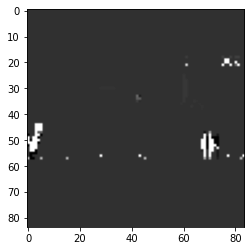

In [11]:
arr = np.reshape(npy[0][3], (84, 84, 1))
fig = plt.figure()
plt.imshow(arr, cmap='gray')
"""img = cv2.imread(arr)
cv2.imshow('Haha', img)"""

In [12]:
path = ".//Screenshots/Screenshots1/jpg"
img = cv2.imread(path)
cv2.imshow('Img', img)

error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-2b5g8ysb\opencv\modules\highgui\src\window.cpp:376: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


In [ ]:
for episodes in range(num_episodes):
    environ.reset()
    state = get_ss.screenshot()
    # While the episode is running
    while not environ.done:
        action = agent.select_action(state, policy_net)
        reward = environ.ta
        

In [15]:
help(count)

NameError: name 'count' is not defined